In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

from M1S_tools import *

plt.jet()

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

In [2]:
start_time = 1732125510
end_time = 1732125780
duration = end_time - start_time

In [3]:
mirror_z, tt = getDBData(start_time,'m1_s1_support_ctrl/s/mirror_position/value', duration_in_s=duration, samples=100)
sa_force, tt = getDBData(start_time,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=duration, samples=100)
g_load, tt = getDBData(start_time,'m1_s1_support_ctrl/s/gravity_load/value', duration_in_s=duration, samples=100)
ofl6, tt = getDBData(start_time,'m1_s1_support_ctrl/s/ofl_correction/value', duration_in_s=duration, samples=100)
ts_idx = mirror_z[:,2]*1000<0  #select times where mirror was fully raised.
sa_force_z_total = np.sum(sa_force[:,:,2], axis=1)
puck_force = np.mean(sa_force[ts_idx], axis=0)[:,2]/npuck

m1_s1_support_ctrl/s/mirror_position/value
2024-11-20 10:58:30  duration =  270  s
(100, 6)
m1_s1_support_ctrl/s/sa_force/value
2024-11-20 10:58:30  duration =  270  s
(100, 170, 3)
m1_s1_support_ctrl/s/gravity_load/value
2024-11-20 10:58:30  duration =  270  s
(100, 6)
m1_s1_support_ctrl/s/ofl_correction/value
2024-11-20 10:58:30  duration =  270  s
(100, 6)


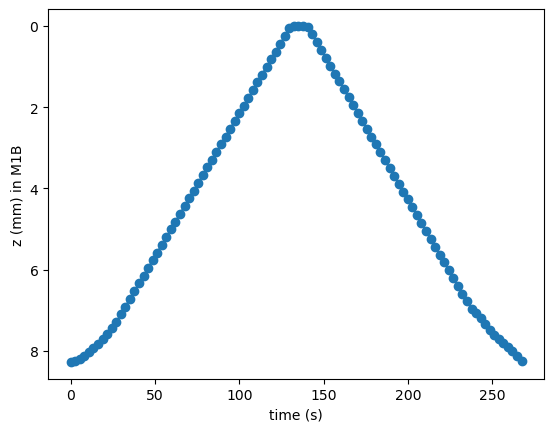

In [4]:
plt.plot(tt-tt[0], mirror_z[:,2]*1e3, '-o');
plt.xlabel('time (s)')
plt.ylabel('z (mm) in M1B')
plt.gca().invert_yaxis();

In [5]:
idx12 = np.ix_(ts_idx,np.array(dfSA['LSActType']==5)) #select 10 actuators under quads
print(sa_force[idx12[0], idx12[1],2]) #select z force only.
print(saID[np.array(dfSA['LSActType']==5)])

[[-834.00738525 -853.00457764 -901.53668213 -848.73693848 -892.17498779
  -833.74493408 -852.04663086 -898.33544922 -850.01806641 -893.54638672]
 [-833.38146973 -849.82666016 -898.65368652 -848.07922363 -892.20678711
  -832.70733643 -850.6293335  -895.63879395 -848.5067749  -892.53588867]
 [-833.14263916 -849.86999512 -896.04968262 -847.699646   -892.89117432
  -832.78381348 -850.05456543 -896.10778809 -848.09625244 -892.31011963]]
[ 144  313  326  113  126 1144 1313 1326 1113 1126]


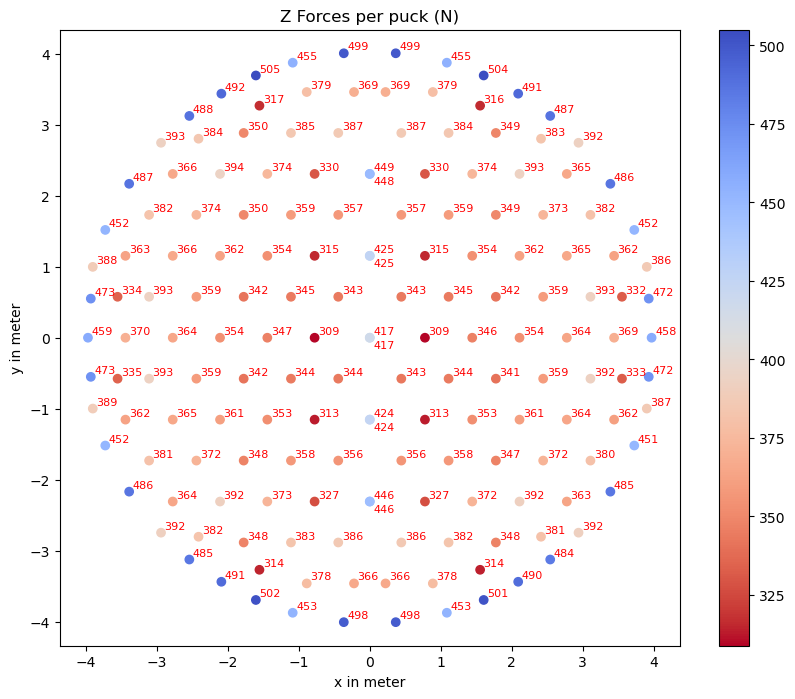

In [6]:
showForceMap(puck_force, 'Z Forces per puck (N)')

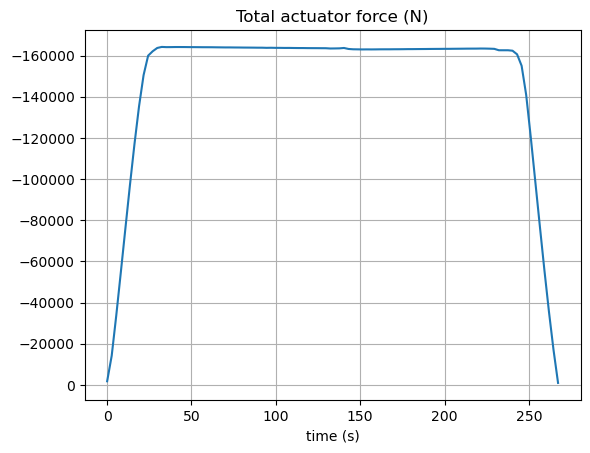

In [7]:
plt.plot(tt-tt[0], sa_force_z_total)
plt.grid()
plt.xlabel('time (s)')
plt.gca().invert_yaxis();
plt.title('Total actuator force (N)');

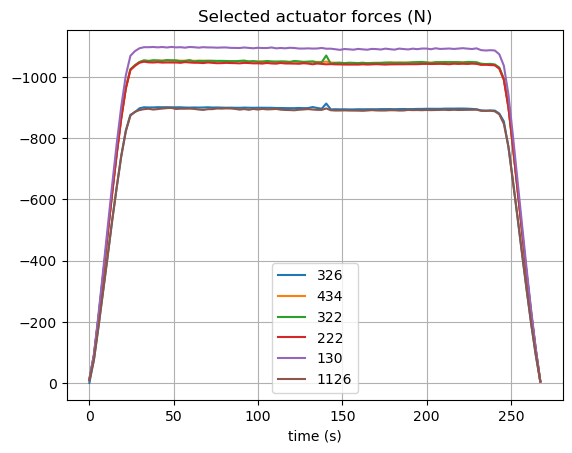

In [8]:
sa_plot = [326, 434, 322, 222, 130, 1126]
for id in sa_plot:
    cc = sa_force[:,saID==id, 2]
    plt.plot(tt-tt[0], cc, label='%d'%id)
plt.grid()
plt.xlabel('time (s)')
plt.legend()
plt.gca().invert_yaxis();
plt.title('Selected actuator forces (N)');

## Force related variables in the DB (all in the M1B coordinate system)

s/gravity_load: 6, The gravity load forces and moments  
s/ofl_correction: 6, The outer force loop correction forces and moments   
s/total_load: 6, The total load forces and moments  
s/x_bending_mode: 90, The bending mode coefficients for the X axis  
s/y_bending_mode: 90, The bending mode coefficients for the Y axis  
s/z_bending_mode: 170, The bending mode coefficients for the Z axis  
s/mirror_force: 6, The outer (=net) forces of the mirror; calculated from hp_force  
s/mirror_force_disturbance: 6, The outer force disturbances of the mirror  
s/hp_force: 6, The force of the hardpoint  
s/sa_support_force: 170x3, The support force offsets of the support actuators.  
s/sa_bending_force: 170x3, The bending force offsets of the support actuators  
s/sa_unsafe_force: 170x3, The total unverified forces of the support actuators  
s/sa_force: 170x3, The total verified forces of the support actuators  
s/sa_force_moment: 6, The force and moments of the total verified forces of the support actuators.  

sa_force = sa_support_force + sa_bending_force  
sa_support_force = k_matrix(gravity_load + ofl_correction)  
The Fz component of gravity_load is nominal mirror weight  
mirror_foce = hp_matrix(hp_force)  

## Other variables might be of interest
s/mirror_state  
s/mirror_motion_mode  
s/mirror_position: 6  
s/mirror_velocity: 6  
s/hp_control_mode  
s/hp_position: 6  
s/hp_velocity: 6  
s/sa_state: 170  

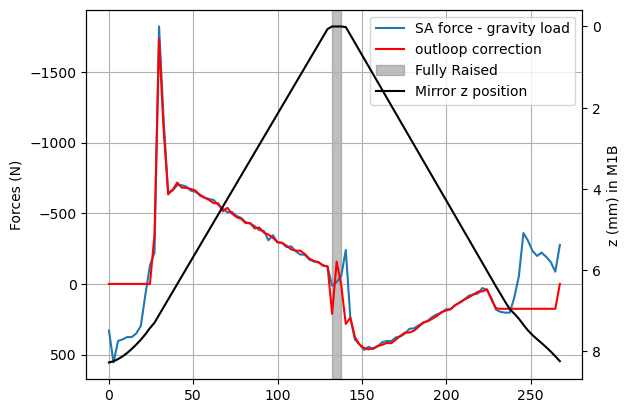

In [9]:
fig, ax1 = plt.subplots()

ax1.plot(tt-tt[0], (sa_force_z_total-g_load[:,2]), label='SA force - gravity load') #visually above y=0 means sa_force is larger than gravity.
ax1.plot(tt-tt[0], ofl6[:,2],'r', label='outloop correction')
ax1.invert_yaxis();

ymin, ymax = ax1.get_ylim()
true_indices = np.where(ts_idx == True)[0]
ax1.fill_betweenx(y=[ymin, ymax], x1=tt[true_indices[0]]-tt[0], x2=tt[true_indices[-1]]-tt[0], 
                  color='gray', alpha=0.5, label="Fully Raised")
ax1.set_ylim([ymin, ymax])
ax1.set_ylabel('Forces (N)')
ax2 = ax1.twinx()

ax2.plot(tt-tt[0], mirror_z[:,2]*1e3, '-k', label='Mirror z position');
ax2.set_xlabel('time (s)')
ax2.set_ylabel('z (mm) in M1B')
#ax2.legend()
ax2.invert_yaxis();

# Merge legends from both axes
# Get handles and labels for both axes
handles, labels = [], []
handles.extend(ax1.get_legend_handles_labels()[0])
labels.extend(ax1.get_legend_handles_labels()[1])
handles.extend(ax2.get_legend_handles_labels()[0])
labels.extend(ax2.get_legend_handles_labels()[1])

# Create a single legend for both axes
ax1.legend(handles, labels)
ax1.grid();
#ax2.grid();
#ax1.legend()

In [10]:
start_time = 1732213163
end_time = 1732213463
duration = end_time - start_time

In [11]:
mirror_z, tt = getDBData(start_time,'m1_s1_support_ctrl/s/mirror_position/value', duration_in_s=duration, samples=100)
sa_force, tt = getDBData(start_time,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=duration, samples=100)
g_load, tt = getDBData(start_time,'m1_s1_support_ctrl/s/gravity_load/value', duration_in_s=duration, samples=100)
ofl6, tt = getDBData(start_time,'m1_s1_support_ctrl/s/ofl_correction/value', duration_in_s=duration, samples=100)
ts_idx = mirror_z[:,2]*1000<0  #select times where mirror was fully raised.
sa_force_z_total = np.sum(sa_force[:,:,2], axis=1)
puck_force = np.mean(sa_force[ts_idx], axis=0)[:,2]/npuck

m1_s1_support_ctrl/s/mirror_position/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)
m1_s1_support_ctrl/s/sa_force/value
2024-11-21 11:19:23  duration =  300  s
(100, 170, 3)
m1_s1_support_ctrl/s/gravity_load/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)
m1_s1_support_ctrl/s/ofl_correction/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)


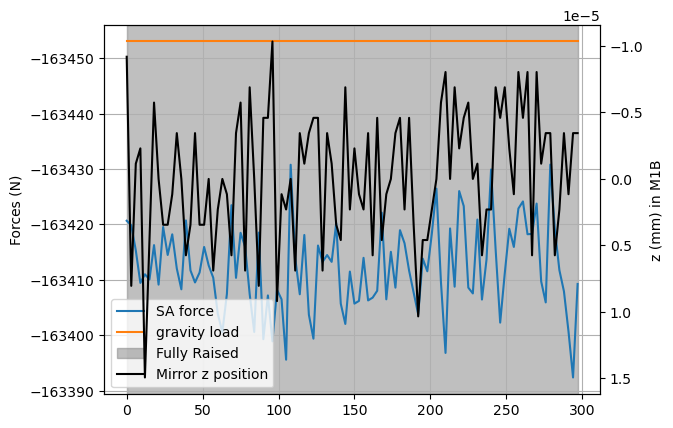

In [12]:
fig, ax1 = plt.subplots()

ax1.plot(tt-tt[0], (sa_force_z_total), label='SA force') #visually above y=0 means sa_force is larger than gravity.
ax1.plot(tt-tt[0], (g_load[:,2]), label='gravity load') #visually above y=0 means sa_force is larger than gravity.
#ax1.plot(tt-tt[0], ofl6[:,2],'r', label='outloop correction')
ax1.invert_yaxis();

ymin, ymax = ax1.get_ylim()
true_indices = np.where(ts_idx == True)[0]
ax1.fill_betweenx(y=[ymin, ymax], x1=tt[true_indices[0]]-tt[0], x2=tt[true_indices[-1]]-tt[0], 
                  color='gray', alpha=0.5, label="Fully Raised")
ax1.set_ylim([ymin, ymax])
ax1.set_ylabel('Forces (N)')
ax2 = ax1.twinx()

ax2.plot(tt-tt[0], mirror_z[:,2]*1e3, '-k', label='Mirror z position');
ax2.set_xlabel('time (s)')
ax2.set_ylabel('z (mm) in M1B')
#ax2.legend()
ax2.invert_yaxis();

# Merge legends from both axes
# Get handles and labels for both axes
handles, labels = [], []
handles.extend(ax1.get_legend_handles_labels()[0])
labels.extend(ax1.get_legend_handles_labels()[1])
handles.extend(ax2.get_legend_handles_labels()[0])
labels.extend(ax2.get_legend_handles_labels()[1])

# Create a single legend for both axes
ax1.legend(handles, labels)
ax1.grid();
#ax2.grid();
#ax1.legend()

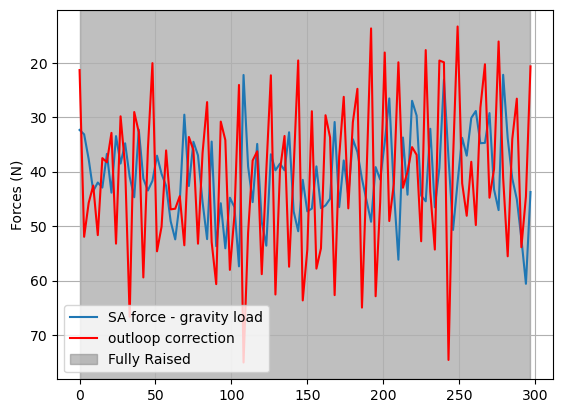

In [13]:
fig, ax1 = plt.subplots()

ax1.plot(tt-tt[0], (sa_force_z_total-g_load[:,2]), label='SA force - gravity load') #visually above y=0 means sa_force is larger than gravity.
ax1.plot(tt-tt[0], ofl6[:,2],'r', label='outloop correction')
ax1.invert_yaxis();

ymin, ymax = ax1.get_ylim()
true_indices = np.where(ts_idx == True)[0]
ax1.fill_betweenx(y=[ymin, ymax], x1=tt[true_indices[0]]-tt[0], x2=tt[true_indices[-1]]-tt[0], 
                  color='gray', alpha=0.5, label="Fully Raised")
ax1.set_ylim([ymin, ymax])
ax1.set_ylabel('Forces (N)')

# Create a single legend for both axes
ax1.legend()
ax1.grid();
#ax2.grid();
#ax1.legend()

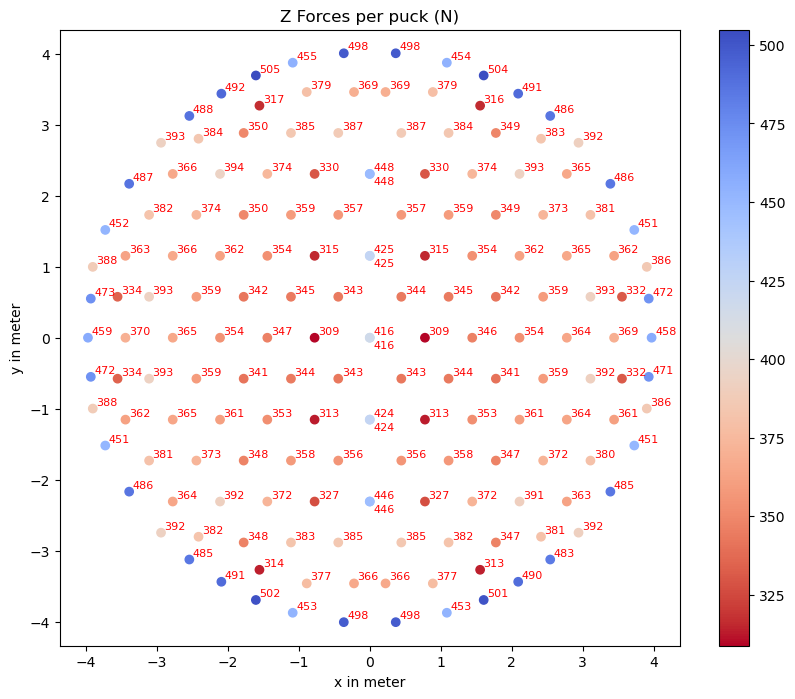

In [14]:
showForceMap(puck_force, 'Z Forces per puck (N)')

### Below, we just print out some sample values of variables, to see what they look like

In [15]:
printDBVar(start_time,'m1_s1_support_ctrl/s/gravity_load/value')

m1_s1_support_ctrl/s/gravity_load/value
2024-11-21 11:19:23
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]


In [16]:
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_state/value')
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_state/goal')
printDBVar(start_time,'m1_s1_support_ctrl/s/gravity_load/value')
printDBVar(start_time,'m1_s1_support_ctrl/s/gravity_load/goal')

m1_s1_support_ctrl/s/mirror_state/value
2024-11-21 11:19:23
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
m1_s1_support_ctrl/s/mirror_state/goal
2024-11-21 11:19:23
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
RUN
m1_s1_support_ctrl/s/gravity_load/value
2024-11-21 11:19:23
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
[2.0017219326103232e-11, 0, -163453, 0, -4.740053515758054e-12, 0]
m1_s1_support_ctrl/s/gravity_load/goal
2024-11-21 11:19:23
[2.001721932

In [17]:
printDBVar(start_time,'m1_s1_support_ctrl/s/total_load/value')
printDBVar(start_time,'m1_s1_support_ctrl/s/total_load/goal')

m1_s1_support_ctrl/s/total_load/value
2024-11-21 11:19:23
[199.63263202118262, 203.70919768516504, -163415.59446761, -476.82509968506645, -283.6498002012059, -327.805876775033]
[199.72492146818263, 203.64922724916505, -163418.33550924, -469.8923908884665, -286.28798047580597, -327.874592989533]
[199.69996958018262, 203.31725691916503, -163421.60123909, -464.9474579082665, -289.62625523640605, -328.032191210183]
[199.71831674818262, 203.70336793316503, -163424.491770705, -459.92739855966647, -291.712324395806, -327.888101581833]
[199.46961975678263, 203.22092621156503, -163427.09226359, -454.76394248046654, -294.56730155420604, -327.32138801723295]
[199.49771972678263, 204.06841182916503, -163428.77205551, -450.26229987246654, -297.5265387138061, -327.5713030433329]
[199.41488336838262, 204.60717949516504, -163430.66336001, -446.38898728626646, -299.86069080840605, -327.66719624758286]
[199.15002199078262, 205.49381942716502, -163431.38642473498, -443.52821574126654, -300.383430032006, 

In [18]:
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_force/value')
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_force/goal')

m1_s1_support_ctrl/s/mirror_force/value
2024-11-21 11:19:23
[0.4860531199999909, 5.69741548, 20.32825750000001, -24.48147275999999, 14.630059640000002, -3.3417481999998486]
[0.7557130799999923, 0.24103574000000005, 13.08599825000001, -33.704665649999974, 15.652779849999991, 3.2830855500001572]
[0.19517623999999367, 2.794836980000006, 17.17487375000001, -19.13861492999998, 12.229148329999985, -4.318784749999857]
[1.1563765799999906, 3.5572866999999975, 17.09068675000001, -21.707076329999985, 12.122720269999993, -3.817117949999872]
[1.9696016699999963, -0.17840869999999498, 13.444518750000013, -28.03989767999997, 18.454311579999956, 1.2561898500002222]
[2.0099617499999964, -2.7789930999999912, 11.245496250000004, -21.819178379999975, 17.75909375999998, 0.2730847500001907]
[1.038064829999998, -3.3665924400000007, 11.105426500000002, -19.614069929999985, 8.902675309999985, -1.2743954999998923]
[2.879891989999996, -6.945091959999999, 7.841003000000007, -15.210292949999998, 6.881227689999971

In [19]:
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_force_disturbance/value')
printDBVar(start_time,'m1_s1_support_ctrl/s/mirror_force_disturbance/goal')

m1_s1_support_ctrl/s/mirror_force_disturbance/value
2024-11-21 11:19:23
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
m1_s1_support_ctrl/s/mirror_force_disturbance/goal
2024-11-21 11:19:23
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
